In [1]:
#실시간 영상에서 이안류를 감지해 서버에 보내는 코드
import os
import json
import torch
import torchvision
from PIL import Image
import cv2
import time
import requests
from requests.exceptions import HTTPError
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision import transforms

# Load trained model checkpoint
def load_model(checkpoint_path, num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the checkpoint with map_location set to 'cpu'
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

# Function to draw bounding boxes on the frame
def draw_boxes_on_frame(frame, boxes, labels):
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
        cv2.putText(frame, f'Class: {label}', (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
    return frame

# Set device to CPU
device = torch.device('cpu')

# Load model
checkpoint_path = './RCNN_checkpoint_epoch0708PARA2GLORY_15.pth'
model = load_model(checkpoint_path, num_classes=2)
model.to(device)
model.eval()

# Set up video capture
cap = cv2.VideoCapture('https://wsb.live.smilecdn.com/wsbrtsp3/stream3.stream/playlist.m3u8')

if not cap.isOpened():
    print("Can't open video.")
    exit()

# Set the interval to 3 seconds
interval = 1

# Transform for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

while True:
    start_time = time.time()
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Convert frame to PIL image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)

    # Transform the image
    image = transform(pil_image).unsqueeze(0).to(device)

    # Perform prediction
    outputs = model(image)

    # Process outputs
    output = outputs[0]
    pred_boxes = output['boxes'].detach().cpu()
    pred_labels = output['labels'].detach().cpu()
    pred_scores = output['scores'].detach().cpu()

    # Apply confidence threshold
    conf_threshold = 0.8
    high_conf_indices = pred_scores > conf_threshold
    pred_boxes = pred_boxes[high_conf_indices]
    pred_labels = pred_labels[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]

    # Apply NMS
    iou_threshold = 0.2
    keep_indices = torchvision.ops.nms(pred_boxes, pred_scores, iou_threshold)
    pred_boxes = pred_boxes[keep_indices]
    pred_labels = pred_labels[keep_indices]
    pred_scores = pred_scores[keep_indices]

    # Remove bounding boxes that are likely to be in the sky region (e.g., top 20% of the image height)
    image_height = frame.shape[0]
    sky_region_threshold = 0.2 * image_height

    filtered_boxes = []
    filtered_labels = []
    for box, label in zip(pred_boxes, pred_labels):
        if box[1] > sky_region_threshold:  # Check if the top-left corner y-coordinate is greater than the threshold
            filtered_boxes.append(box)
            filtered_labels.append(label)

    filtered_boxes = torch.stack(filtered_boxes) if filtered_boxes else torch.empty((0, 4))
    filtered_labels = torch.tensor(filtered_labels)

    # Draw the frame with bounding boxes
    frame_with_boxes = draw_boxes_on_frame(frame, filtered_boxes, filtered_labels)
    cv2.imshow('CCTV Feed', frame_with_boxes)

    # Check if any bounding boxes were detected
    if len(filtered_boxes) > 0:
        # Get current time in the desired format
        current_time = time.strftime("%Y%m%d_%H%M%S")

        # Prepare the data for the POST request
        bounding_count = len(filtered_boxes)
        drawing = [[[int(box[0]), int(box[1])], [int(box[2]), int(box[1])], [int(box[2]), int(box[3])], [int(box[0]), int(box[3])]] for box in filtered_boxes]
        data = {
            "date_time": current_time,
            "bounding_count": bounding_count,
            "drawing": drawing
        }

        # Send the data to the server
        url = "https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData"
        #http://localhost:8000/ripData
        #"https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData"
        headers = {
            "Content-Type": "application/json"
        }

        try:
            response = requests.post(url, data=json.dumps(data), headers=headers)
            response.raise_for_status()
            print("POST 요청 성공")
            print("응답 데이터:", response.json())
        except HTTPError as http_err:
            print(f"HTTP 에러 발생: {http_err}")
            print("응답 내용:", response.text)
        except Exception as err:
            print(f"다른 에러 발생: {err}")

    # Wait for the next interval
    while (time.time() - start_time) < interval:
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()



KeyboardInterrupt



In [7]:
print('hellㄴㄴㄴo')

hellㄴㄴㄴo


Can't open video.
Failed to grab frame.


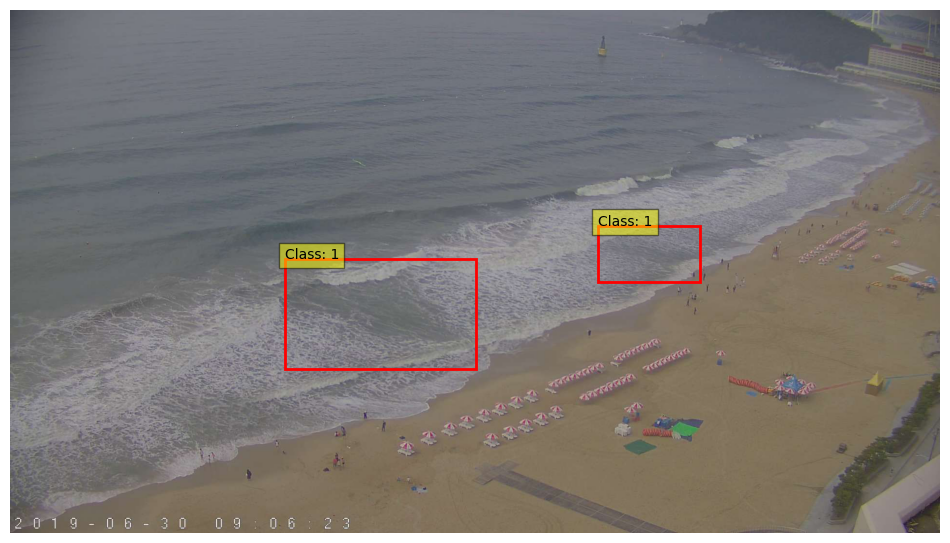

POST 요청 성공
다른 에러 발생: Expecting value: line 1 column 1 (char 0)


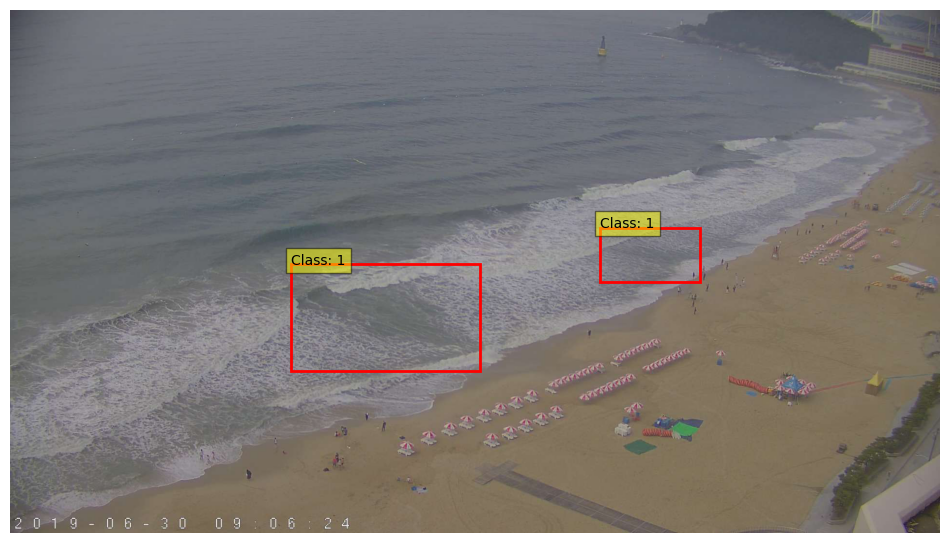

POST 요청 성공
다른 에러 발생: Expecting value: line 1 column 1 (char 0)


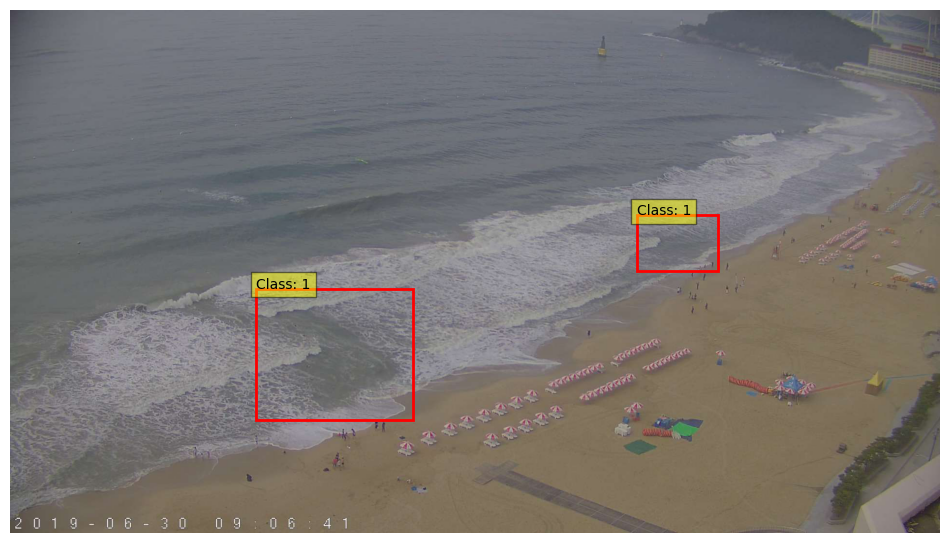

KeyboardInterrupt: 

In [3]:
#데이터셋에서 이안류를 감지해 서버에 보내는 코드
import os
import json
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from requests.exceptions import HTTPError
import requests
import time
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import nms

# Custom FastRCNNPredictor
class FastRCNNPredictor(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = torch.nn.Linear(in_channels, num_classes)
        self.bbox_pred = torch.nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            x = torch.flatten(x, start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

# Load trained model checkpoint
def load_model(checkpoint_path, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load the checkpoint with map_location set to 'cpu'
    map_location = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

# Function to draw bounding boxes on the frame
def draw_boxes_on_image(image, boxes, labels):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Class: {label}', bbox={'facecolor': 'yellow', 'alpha': 0.5})
    plt.axis('off')
    plt.show()

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
checkpoint_path = './RCNN_checkpoint_epoch0708PARA2GLORY_15.pth'
model = load_model(checkpoint_path, num_classes=2)
model.to(device)
model.eval()

# Image directory
image_dir = './image/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Transform for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# NMS parameters
iou_threshold = 0.5
conf_threshold = 0.5

# Process each image
for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Perform prediction
    outputs = model(image_tensor)
    
    # Process outputs
    output = outputs[0]
    pred_boxes = output['boxes'].detach().cpu()
    pred_labels = output['labels'].detach().cpu()
    pred_scores = output['scores'].detach().cpu()
    
    # Apply confidence threshold
    high_conf_indices = pred_scores > conf_threshold
    pred_boxes = pred_boxes[high_conf_indices]
    pred_labels = pred_labels[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]

    # Apply NMS
    keep_indices = nms(pred_boxes, pred_scores, iou_threshold)
    pred_boxes = pred_boxes[keep_indices]
    pred_labels = pred_labels[keep_indices]
    pred_scores = pred_scores[keep_indices]
    
    # Remove bounding boxes that are likely to be in the sky region (e.g., top 20% of the image height)
    image_height = image_tensor.shape[2]
    sky_region_threshold = 0.2 * image_height

    filtered_boxes = []
    filtered_labels = []
    for box, label in zip(pred_boxes, pred_labels):
        if box[1] > sky_region_threshold:  # Check if the top-left corner y-coordinate is greater than the threshold
            filtered_boxes.append(box)
            filtered_labels.append(label)

    filtered_boxes = torch.stack(filtered_boxes) if filtered_boxes else torch.empty((0, 4))
    filtered_labels = torch.tensor(filtered_labels)
    
    # Plot the image with bounding boxes
    draw_boxes_on_image(image, filtered_boxes, filtered_labels)

    # Check if any bounding boxes were detected
    if len(filtered_boxes) > 0:
        # Get current time in the desired format
        current_time = time.strftime("%Y%m%d_%H%M%S")

        # Prepare the data for the POST request
        bounding_count = len(filtered_boxes)
        drawing = [[[int(box[0]), int(box[1])], [int(box[2]), int(box[1])], [int(box[2]), int(box[3])], [int(box[0]), int(box[3])]] for box in filtered_boxes]
        data = {
            "date_time": current_time,
            "bounding_count": bounding_count,
            "drawing": drawing
        }

        # Send the data to the server
        url = "https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData"
        headers = {
            "Content-Type": "application/json"
        }

        try:
            response = requests.post(url, data=json.dumps(data), headers=headers)
            response.raise_for_status()
            print("POST 요청 성공")
            print("응답 데이터:", response.json())
        except HTTPError as http_err:
            print(f"HTTP 에러 발생: {http_err}")
            print("응답 내용:", response.text)
        except Exception as err:
            print(f"다른 에러 발생: {err}")


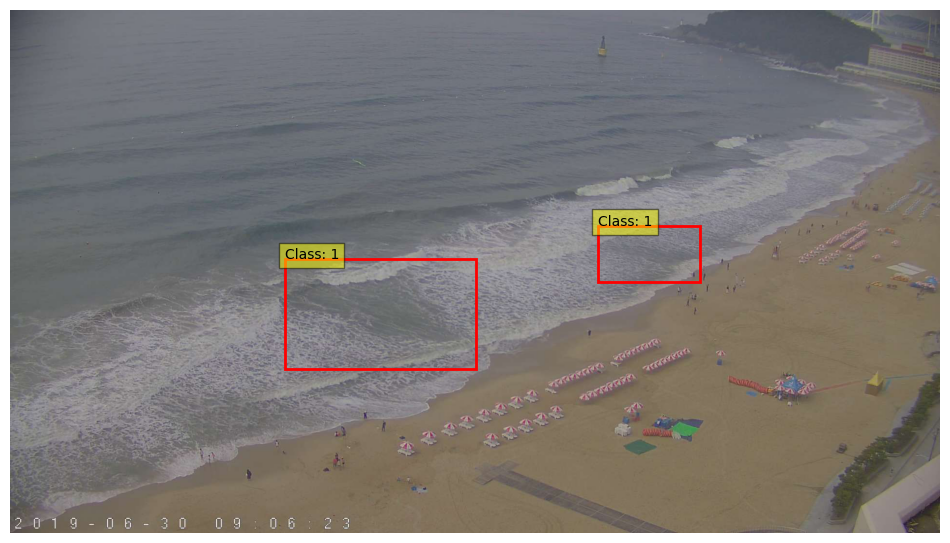

HTTP 에러 발생: 400 Client Error:  for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: {"timestamp":"2024-07-26T06:52:19.252+00:00","status":400,"error":"Bad Request","path":"/ripData"}


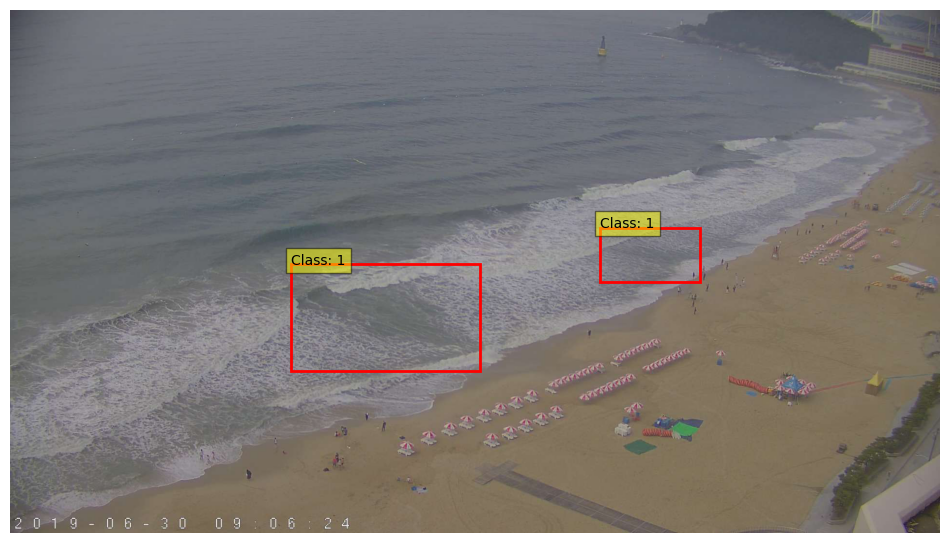

HTTP 에러 발생: 503 Server Error: Service Unavailable for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: <!DOCTYPE html><html><head><meta charset="utf-8"><meta name="robots" content="noindex"><script defer src="https://files.cloudtype.io/errorpages/assets/app.61938851.js"></script><link rel="stylesheet" href="https://files.cloudtype.io/errorpages/assets/app.5111bad7.css"></head><body><div id="app"></div></body></html>


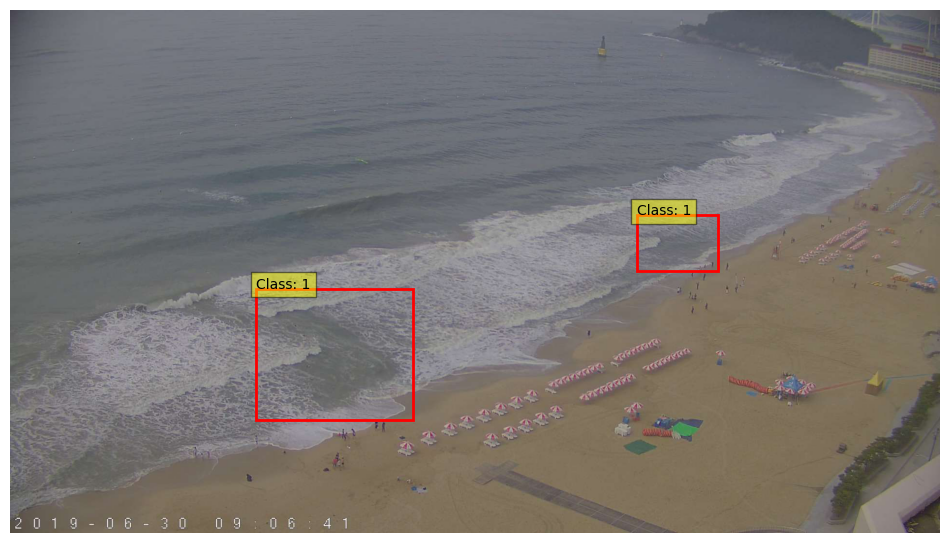

HTTP 에러 발생: 503 Server Error: Service Unavailable for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: <!DOCTYPE html><html><head><meta charset="utf-8"><meta name="robots" content="noindex"><script defer src="https://files.cloudtype.io/errorpages/assets/app.61938851.js"></script><link rel="stylesheet" href="https://files.cloudtype.io/errorpages/assets/app.5111bad7.css"></head><body><div id="app"></div></body></html>


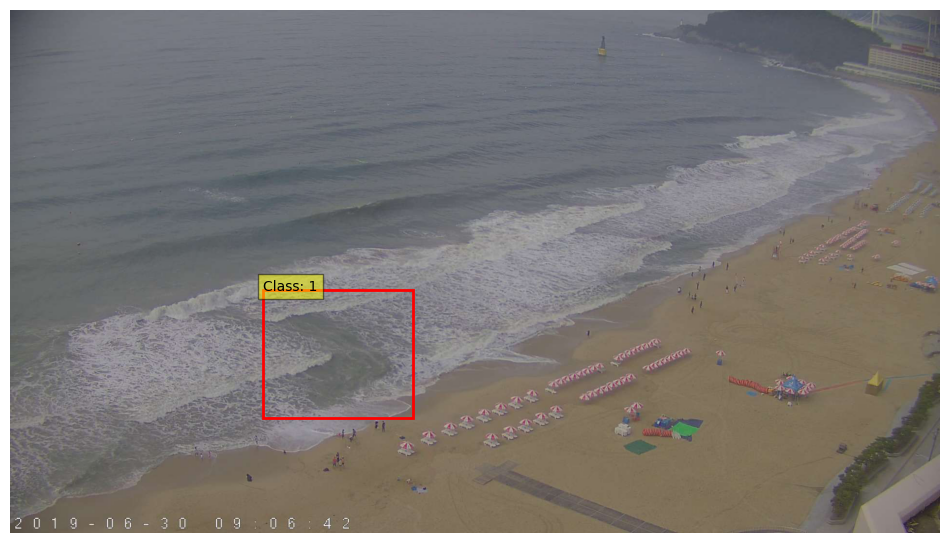

HTTP 에러 발생: 503 Server Error: Service Unavailable for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: <!DOCTYPE html><html><head><meta charset="utf-8"><meta name="robots" content="noindex"><script defer src="https://files.cloudtype.io/errorpages/assets/app.61938851.js"></script><link rel="stylesheet" href="https://files.cloudtype.io/errorpages/assets/app.5111bad7.css"></head><body><div id="app"></div></body></html>


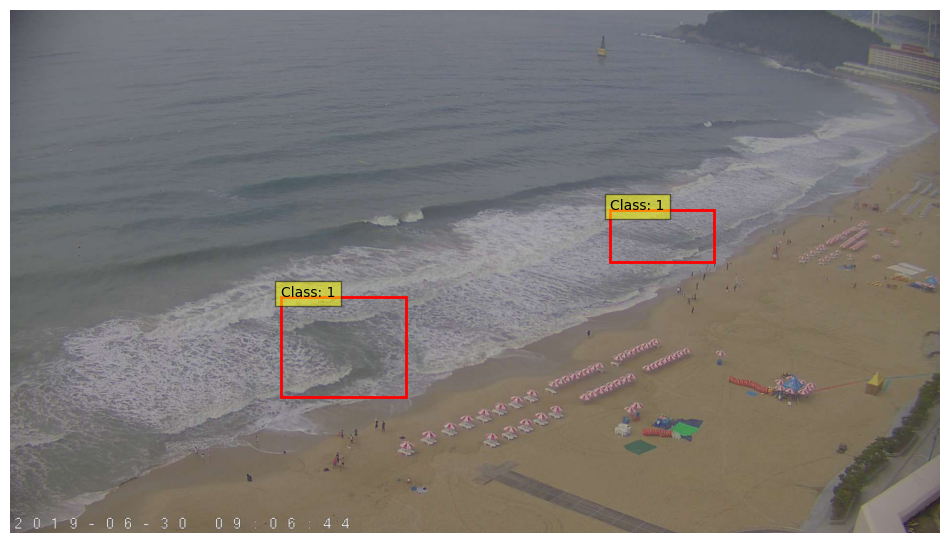

HTTP 에러 발생: 503 Server Error: Service Unavailable for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: <!DOCTYPE html><html><head><meta charset="utf-8"><meta name="robots" content="noindex"><script defer src="https://files.cloudtype.io/errorpages/assets/app.61938851.js"></script><link rel="stylesheet" href="https://files.cloudtype.io/errorpages/assets/app.5111bad7.css"></head><body><div id="app"></div></body></html>


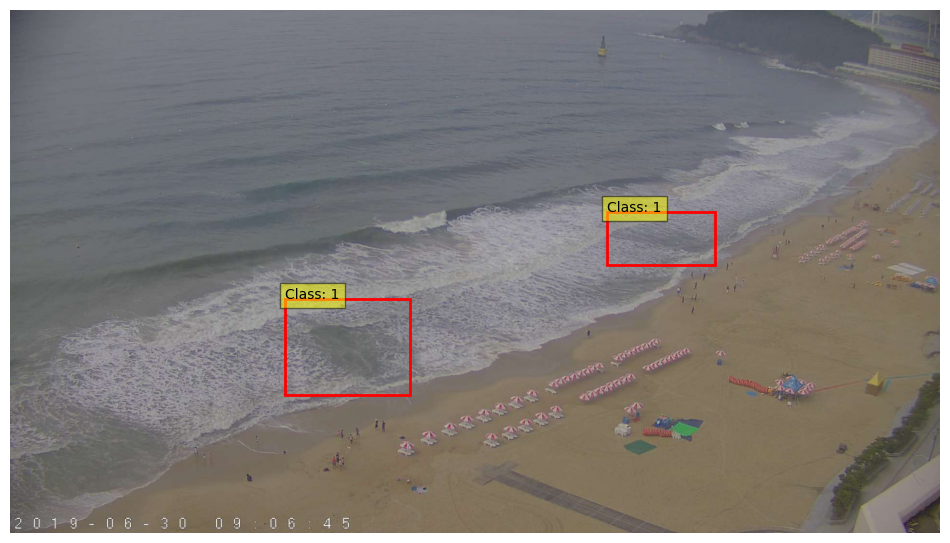

HTTP 에러 발생: 503 Server Error: Service Unavailable for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: <!DOCTYPE html><html><head><meta charset="utf-8"><meta name="robots" content="noindex"><script defer src="https://files.cloudtype.io/errorpages/assets/app.61938851.js"></script><link rel="stylesheet" href="https://files.cloudtype.io/errorpages/assets/app.5111bad7.css"></head><body><div id="app"></div></body></html>


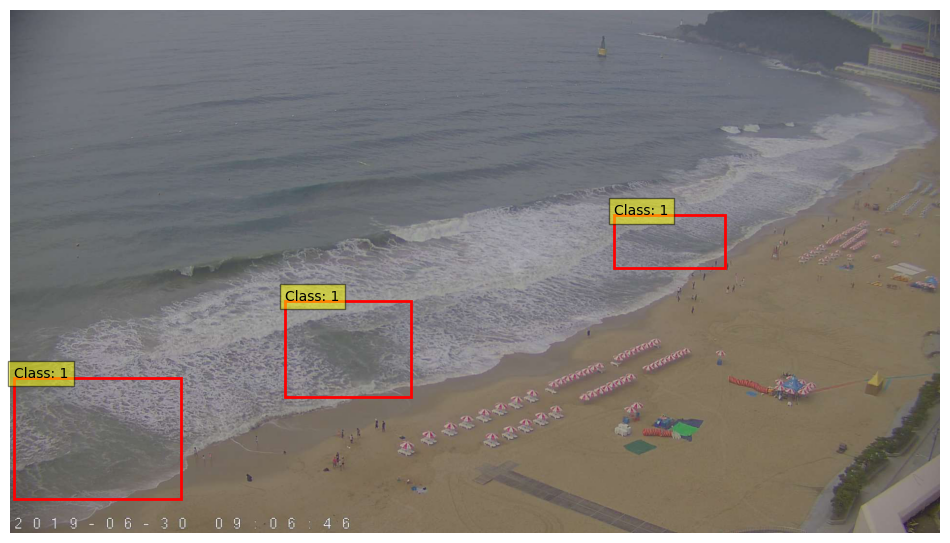

HTTP 에러 발생: 503 Server Error: Service Unavailable for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: <!DOCTYPE html><html><head><meta charset="utf-8"><meta name="robots" content="noindex"><script defer src="https://files.cloudtype.io/errorpages/assets/app.61938851.js"></script><link rel="stylesheet" href="https://files.cloudtype.io/errorpages/assets/app.5111bad7.css"></head><body><div id="app"></div></body></html>


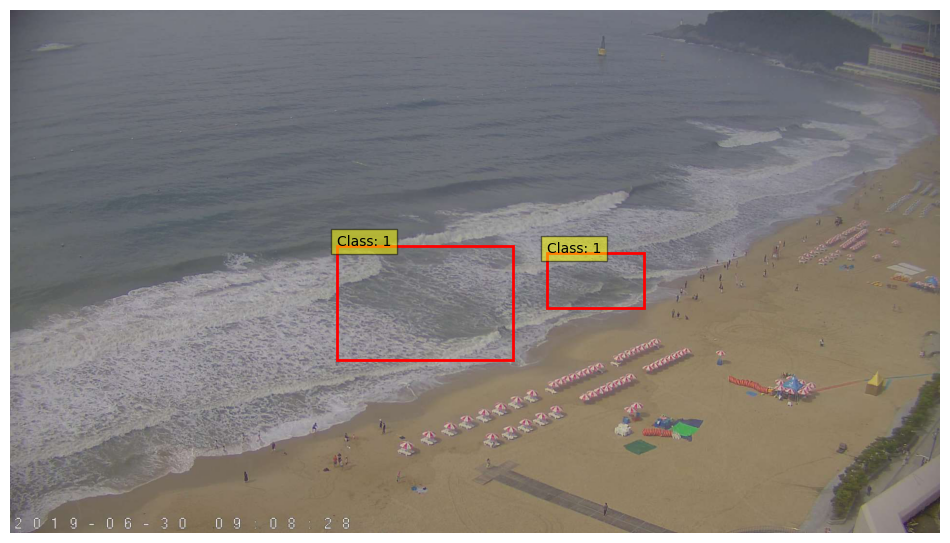

HTTP 에러 발생: 503 Server Error: Service Unavailable for url: https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData
응답 내용: <!DOCTYPE html><html><head><meta charset="utf-8"><meta name="robots" content="noindex"><script defer src="https://files.cloudtype.io/errorpages/assets/app.61938851.js"></script><link rel="stylesheet" href="https://files.cloudtype.io/errorpages/assets/app.5111bad7.css"></head><body><div id="app"></div></body></html>


In [29]:
import os
import json
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from requests.exceptions import HTTPError
import requests
import time
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import nms

# Custom FastRCNNPredictor
class FastRCNNPredictor(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = torch.nn.Linear(in_channels, num_classes)
        self.bbox_pred = torch.nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            x = torch.flatten(x, start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

# Load trained model checkpoint
def load_model(checkpoint_path, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load the checkpoint with map_location set to 'cpu'
    map_location = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

# Function to draw bounding boxes on the frame
def draw_boxes_on_image(image, boxes, labels):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Class: {label}', bbox={'facecolor': 'yellow', 'alpha': 0.5})
    plt.axis('off')
    plt.show()

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
checkpoint_path = './RCNN_checkpoint_epoch0708PARA2GLORY_15.pth'
model = load_model(checkpoint_path, num_classes=2)
model.to(device)
model.eval()

# Image directory
image_dir = './image/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Transform for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# NMS parameters
iou_threshold = 0.5
conf_threshold = 0.5

# Process each image
for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Perform prediction
    outputs = model(image_tensor)
    
    # Process outputs
    output = outputs[0]
    pred_boxes = output['boxes'].detach().cpu()
    pred_labels = output['labels'].detach().cpu()
    pred_scores = output['scores'].detach().cpu()
    
    # Apply confidence threshold
    high_conf_indices = pred_scores > conf_threshold
    pred_boxes = pred_boxes[high_conf_indices]
    pred_labels = pred_labels[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]

    # Apply NMS
    keep_indices = nms(pred_boxes, pred_scores, iou_threshold)
    pred_boxes = pred_boxes[keep_indices]
    pred_labels = pred_labels[keep_indices]
    pred_scores = pred_scores[keep_indices]
    
    # Remove bounding boxes that are likely to be in the sky region (e.g., top 20% of the image height)
    image_height = image_tensor.shape[2]
    sky_region_threshold = 0.2 * image_height

    filtered_boxes = []
    filtered_labels = []
    for box, label in zip(pred_boxes, pred_labels):
        if box[1] > sky_region_threshold:  # Check if the top-left corner y-coordinate is greater than the threshold
            filtered_boxes.append(box)
            filtered_labels.append(label)

    filtered_boxes = torch.stack(filtered_boxes) if filtered_boxes else torch.empty((0, 4))
    filtered_labels = torch.tensor(filtered_labels)
    
    # Plot the image with bounding boxes
    draw_boxes_on_image(image, filtered_boxes, filtered_labels)

    # Check if any bounding boxes were detected
    if len(filtered_boxes) > 0:
        # Get current time in the desired format
        current_time = time.strftime("%Y%m%d_%H%M%S")

        # Prepare the data for the POST request
        bounding_count = len(filtered_boxes)
        drawing = [[[int(box[0]), int(box[1])], [int(box[2]), int(box[1])], [int(box[2]), int(box[3])], [int(box[0]), int(box[3])]] for box in filtered_boxes]
        data = {
            "date_time": current_time,
            "bounding_count": bounding_count,
            "drawing": drawing
        }

        # Send the data to the server
        url = "https://port-0-rip-lyuhc4uac61f92ea.sel4.cloudtype.app/ripData"
        headers = {
            "Content-Type": "application/json"
        }

        try:
            response = requests.post(url, data=json.dumps(data), headers=headers)
            response.raise_for_status()
            print("POST 요청 성공")
            print("응답 데이터:", response.json())
        except HTTPError as http_err:
            print(f"HTTP 에러 발생: {http_err}")
            print("응답 내용:", response.text)
        except Exception as err:
            print(f"다른 에러 발생: {err}")
